In [1]:
import pandas as pd
import spacy
import numpy as np
import string
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [3]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [4]:
nlp = spacy.load("en_core_web_sm")
class SyntacticFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Feature 1: Sentence length (number of tokens)
            sentence_length = len(doc)
            # Feature 2: Punctuation count
            punctuation_count = sum(1 for token in doc if token.text in string.punctuation)
            # Feature 3: Count of nouns, verbs, adjectives
            noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
            verb_count = sum(1 for token in doc if token.pos_ == "VERB")
            adj_count = sum(1 for token in doc if token.pos_ == "ADJ")
            # Feature 4: Count of stopwords
            stopword_count = sum(token.is_stop for token in doc)

            features.append([sentence_length, punctuation_count, noun_count, verb_count, adj_count, stopword_count])
        return np.array(features)

# Custom transformer to extract named entity features
class NamedEntityFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.entity_types = ['PERSON', 'ORG', 'GPE', 'DATE', 'MONEY', 'CARDINAL', 'NORP', 'PERCENT']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Total number of entities in the sentence
            total_entities = len(doc.ents)
            # Count of specific entity types
            type_counts = {etype: 0 for etype in self.entity_types}
            for ent in doc.ents:
                if ent.label_ in type_counts:
                    type_counts[ent.label_] += 1
            # Combine features: total entities + counts for each type
            feature_row = [total_entities] + [type_counts[etype] for etype in self.entity_types]
            features.append(feature_row)
        return np.array(features)

# Combine TF-IDF features with syntactic and named entity features
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 3))),
    ('syntactic', SyntacticFeaturesExtractor()),
    ('entities', NamedEntityFeaturesExtractor())
])

In [5]:
X_train_combined_features = combined_features.fit_transform(X_train)
X_val_combined_features = combined_features.transform(X_val)


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_combined_features_oversampled, y_train_oversampled = smote.fit_resample(X_train_combined_features, y_train)
smote_class_counts = y_train_oversampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 11759 samples
Class 0: 11759 samples
Class 1: 11759 samples


In [20]:
from sklearn.decomposition import TruncatedSVD
y_train_mapped = y_train_oversampled.values + 1
y_val_mapped = y_val.values + 1

nn = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=40,
    early_stopping=True,
    validation_fraction=0.2,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=5,
    verbose=1,
    random_state=42
)
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('reduce_dim', TruncatedSVD(n_components=3000)),  # Reduce to 300 components
    ('classifier', nn)
])
pipeline.fit(X_train_combined_features_oversampled, y_train_mapped)

Iteration 1, loss = 0.56976418
Validation score: 0.879110
Iteration 2, loss = 0.18831430
Validation score: 0.899802
Iteration 3, loss = 0.11837238
Validation score: 0.899376
Iteration 4, loss = 0.08988951
Validation score: 0.911139
Iteration 5, loss = 0.08426448
Validation score: 0.911423
Iteration 6, loss = 0.06601607
Validation score: 0.910714
Iteration 7, loss = 0.05498283
Validation score: 0.916525
Iteration 8, loss = 0.05772315
Validation score: 0.908730
Iteration 9, loss = 0.06616989
Validation score: 0.906037
Iteration 10, loss = 0.06493764
Validation score: 0.911848
Iteration 11, loss = 0.05489115
Validation score: 0.912982
Iteration 12, loss = 0.03925306
Validation score: 0.917092
Iteration 13, loss = 0.03881941
Validation score: 0.912982
Iteration 14, loss = 0.03839585
Validation score: 0.913832
Iteration 15, loss = 0.03583538
Validation score: 0.919785
Iteration 16, loss = 0.03581195
Validation score: 0.916525
Iteration 17, loss = 0.03564720
Validation score: 0.917375
Iterat

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('reduce_dim', TruncatedSVD(n_components=3000)),
                ('classifier',
                 MLPClassifier(batch_size=64, early_stopping=True,
                               hidden_layer_sizes=(256, 128, 64),
                               learning_rate='adaptive', max_iter=40,
                               random_state=42, validation_fraction=0.2,
                               verbose=1))])

In [ ]:
scaler = StandardScaler(with_mean=False)
scaled = scaler.fit_transform(X_train_combined_features_oversampled)



0.6263547614594408

In [27]:
svd = TruncatedSVD(n_components=5000)
svd.fit(scaled)
svd.explained_variance_ratio_.sum()

0.8071401339413038

In [21]:
pipeline["reduce_dim"].explained_variance_ratio_.sum()

0.6263530516520266

Accuracy on the validation set: 71.47%
Macro F1 Score: 0.5709
F1 Score per class: [0.8263854  0.31135135 0.57509506]
Confusion matrix saved as 'confusion_matrix.png'


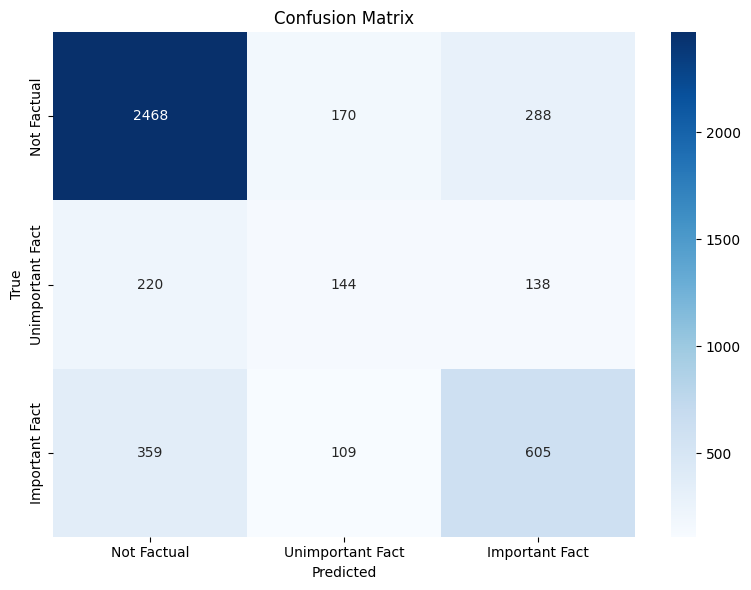

In [22]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

y_val_pred = pipeline.predict(X_val_combined_features) # using 10k features from tfidf

# Evaluate the model
accuracy = accuracy_score(y_val_mapped, y_val_pred)
f1 = f1_score(y_val_mapped, y_val_pred, average='macro')
f1_per_class = f1_score(y_val_mapped, y_val_pred, average=None)

print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')
print(f'Macro F1 Score: {f1:.4f}')
print(f'F1 Score per class: {f1_per_class}')

# Create and plot confusion matrix
cm = confusion_matrix(y_val_mapped, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [17]:
import joblib

pipeline = Pipeline([
    ('features', combined_features),
    ('logreg', logreg)
])
joblib.dump(pipeline, 'features_tfidf10k_logreg_model.pkl')
print("Model saved as 'features_tfidf10k_logreg_model.pkl'")

Model saved as 'features_tfidf10k_logreg_model.pkl'


In [18]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions - 1
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('features_tfidf10k_logreg_model.pkl', 'data/test.csv', 'data/features_tfidf10k_logreg_predictions.csv')


Making predictions on test data...
Predictions saved to data/features_tfidf10k_logreg_predictions.csv


In [20]:
print(pipeline)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=10000,
                                                                 ngram_range=(1,
                                                                              3))),
                                                ('syntactic',
                                                 SyntacticFeaturesExtractor()),
                                                ('entities',
                                                 NamedEntityFeaturesExtractor())])),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1500))])
